# Problem Formulation

You are working in partnership with a renowned Dermatology Clinic in town to help them quickly triage patients coming to the clinic and screen for possible pre-cancerous cases. If the pre-cancerous cases are detected by your model, the patient may get early appointment and referred to the Skin Cancer Consultant directly. For this task, the clinic has been collected dermoscopic images since past six months. Currently, 900 images have been collected.

It can be quite hard to diagnose pre-cancerous vs non-pre-cancerous skin lesion. So, there are team of 5 experts who will provide required expertise in helping identify and label these collected images. Every week they gather and discuss 10 patient images taking in total approximately 1 hour. Unfortunately, given the time constraint and busy clinical practice schedule, an hour a week is the only time that can be appointed for data labelling.   

The data labelling process has started since last month and hence the team has been able to label 40 patient images up until now.

In [10]:
# imports 
from glob import glob 
import random
import torchvision
import torch
from torchvision.transforms import Compose, Lambda, ToTensor, Resize
from PIL import Image
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
from torchvision import transforms
import PIL
from semilearn.datasets.augmentations.transforms import get_image_strong_augment_nocolor_transform

In [11]:
# the dataset for this task can be downloaded here
isic_challenge_train_image_download_link = 'https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3B_Training_Data.zip'
isic_challenge_train_label_download_link = 'https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv'
isic_challenge_test_image_download_link = 'https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3B_Test_Data.zip'
isic_challenge_test_label_download_link = 'https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3B_Test_GroundTruth.csv'

In [12]:
# image root directory
image_dir = 'isic_challenge/ISBI2016_ISIC_Part3B_Training_Data'
images = glob(f'{image_dir}/ISIC_*.jpg')

# TODO: how many data has been collected?
print(f'Total Data (Images) available {len(images)}')

Total Data (Images) available 900


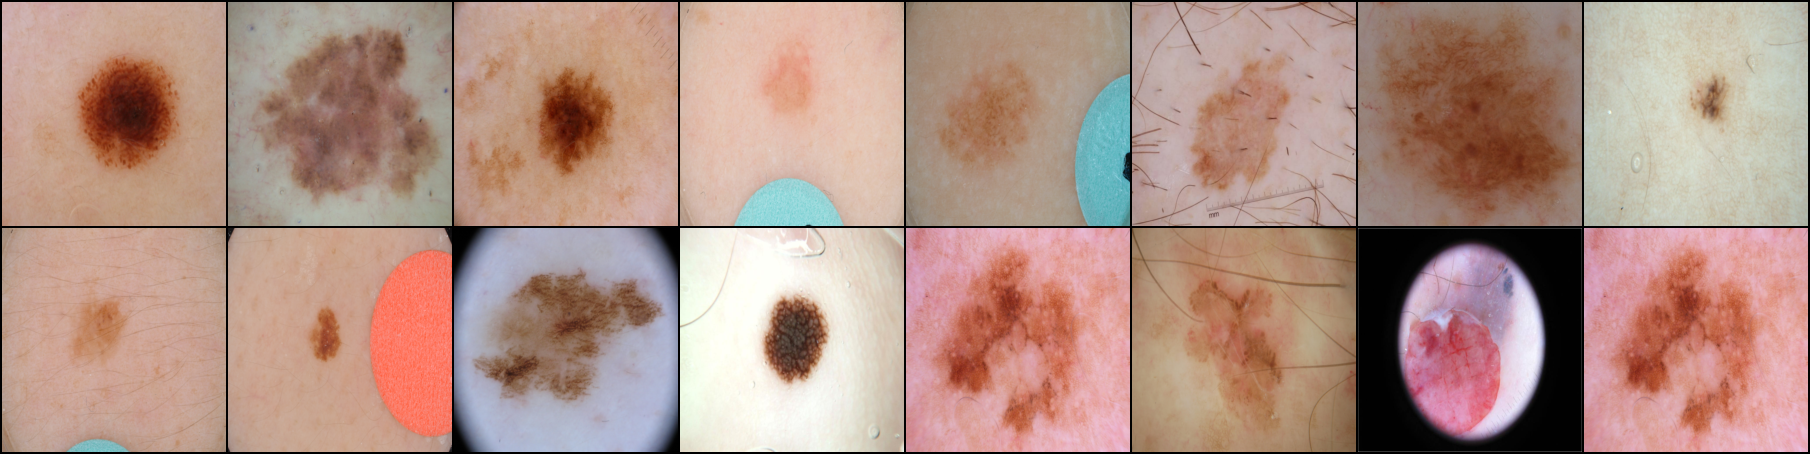

In [13]:
# a sample of these images look like below
NUM_SAMPLES = 16
sample_img_paths = random.choices(images,k=NUM_SAMPLES)
img_transform = Compose([
    Lambda(Image.open),
    Resize(size=(224,224)),
    ToTensor()
])
sample_images = torch.stack([img_transform(img) for img in sample_img_paths])
to_pil_image(make_grid(sample_images,nrow=8))


In [14]:
# the labelled samples up until now
NUM_LABELLED = 40
train_label_path = 'isic_challenge/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv'
label_df = pd.read_csv(train_label_path,header=None)
labelled_subset_index = [random.randint(0, len(label_df)-1) for x in range(NUM_LABELLED)]

labelled_patients, labels = label_df[0][labelled_subset_index],label_df[1][labelled_subset_index]
print(f"Total labeled patients {len(labelled_patients)} labels, Benign : {sum(labels=='benign')} Malignant: {sum(labels=='malignant')}")


Total labeled patients 40 labels, Benign : 34 Malignant: 6


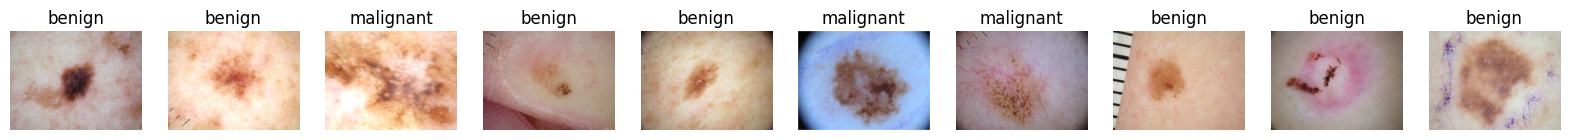

In [15]:
# visualize the labelled images
NCOL = 10
SCALE = 2
fig, axes = plt.subplots(1,NCOL,figsize=(NCOL*SCALE,SCALE))
for i,ax in enumerate(axes):
    full_img_path = join(image_dir,f'{labelled_patients.iloc[i]}.jpg')
    ax.imshow(plt.imread(full_img_path))
    ax.axis('off')
    ax.set_title(f'{labels.iloc[i]}')

In [16]:
# we may starting training on the available 40 images using supervised learning paradigm discussed in the earlier weeks
# TODO: show training results on limited training data using off-the-shelf architecture

### Discussion: Going beyond Supervised Learning

In [17]:
# We know from past experience that Machine Learning and especially Deep Learning Models require huge amount of data, possibly in ~thousands if not millions which we do not have for now.
# TODO: Discuss -> Given our dire circumstances, what alternative paradigms may be available in this case? 
# Discuss -> Can we possibly use the already available unlabelled images to improve the AI system's performance? In future too, we may have abundant amount of unlabelled images which we might leverage. 

In [18]:
# TODO: Write code and experiment to verify that we were able to leverage the unlabelled data and were able to improve model performance

### Concepts to be introduced 

#### Semi-supervised Learning : How can we use limited labelled and leverage unlabelled data?
- smoothness assumption
- cluster/manifold assumption
- Pseudo labels
- Weak vs Strong Augmentation

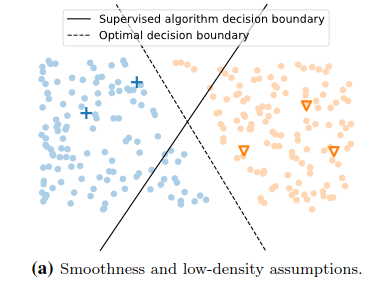
###### Original Paper : A survey on semi-supervised learning https://link.springer.com/article/10.1007/s10994-019-05855-6


##### We are going to use a off-the-shelf tried-and-test EfficientNet Architecture for this task
![efficientnet](https://skyengine.ai/se/images/blog/Architecture-of-EfficientNet-B0-with-MBConv-as-Basic-building-blocks.png)
###### Original paper: https://arxiv.org/pdf/1905.11946v5.pdf


#### Fixmatch : Simplifying Semi-Supervised Learning with Consistency and Confidence
###### Original Paper: https://arxiv.org/ftp/arxiv/papers/2001/2001.07685.pdf

We will work through code implementation of one of the concrete example of Semi-Supervised learning applied to our skin-lesion classification problem.
We have picked an Algorithm called Fixmatch that uses confidence score and Consistency loss to leverage available unlabelled data. 

![fixmatch](docs/fixmatch-35.png)

##### Weak vs Strong Augmentation

In [27]:
IMG_SIZE = 224
def get_strong_augmentation(IMG_SIZE=224):
    data_transform = transforms.Compose(
        [
            transforms.Lambda(PIL.Image.open),
            # aggressive augmentation start
            transforms.RandomInvert(),
            transforms.RandomAffine(degrees=45,scale=(0.7,1.3),shear=(0.75,1.5)),
            transforms.RandomErasing(),
            # aggressive augmentation end
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.Resize(size=(IMG_SIZE+28,IMG_SIZE+28),antialias=True),
            transforms.RandomCrop(size=(IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            # transforms.RandomAdjustSharpness(sharpness_factor=0.5),
        ]
    )
    return data_transform

def get_weak_augmentation(IMG_SIZE=224):
    data_transform = transforms.Compose(
        [
            transforms.Lambda(PIL.Image.open),
            transforms.ToTensor(),
            transforms.RandomAutocontrast(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
        ]
    )
    return data_transform

def get_no_augmentation(IMG_SIZE=224):
    data_transform = transforms.Compose([
        transforms.Lambda(PIL.Image.open),
        transforms.ToTensor(),
        transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    ])
    return data_transform

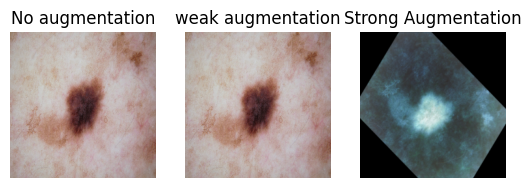

In [36]:
# Weak vs Strong Augmentation
sample_img_path = join(image_dir,f'{labelled_patients.iloc[0]}.jpg')
no_augmentation = get_no_augmentation()(sample_img_path)
weak_augmented_img = get_weak_augmentation(IMG_SIZE)(sample_img_path)
strongly_augmented_img = get_strong_augmentation(IMG_SIZE)(sample_img_path)

fig,axes = plt.subplots(1,3)
axes[0].imshow(transforms.ToPILImage()(no_augmentation)) # convert to PIL for visualization
axes[0].axis('off')
axes[0].set_title('No augmentation')
axes[1].imshow(transforms.ToPILImage()(weak_augmented_img)) # convert to PIL for visualization
axes[1].axis('off')
axes[1].set_title('weak augmentation')
axes[2].imshow(transforms.ToPILImage()(strongly_augmented_img)) # same
axes[2].set_title('Strong Augmentation')
axes[2].axis('off')
plt.show()


In [136]:
# TODO: write full training code to leverage the unlabelled data

weak_augmentation = get_weak_augmentation()
strong_augmentation = get_strong_augmentation()
P_CUTOFF = 0.95 # confidence threshold
lambda_u = 1.0 # how much do we want to use the loss from the unlabelled data
def fixmatch_training_step(unlabeled_batch_data, labeled_batch_data,optimizer, model, criterion, device = 'cpu' ):
    inputs, labels = labeled_batch_data[0].to(device), labeled_batch_data[1].to(device)
    optimizer.zero_grad()

    # supervised loss
    pred_logits = model(inputs)
    supervised_loss = criterion(pred_logits, labels)

    # self-supervised loss
    unlabelled_input, _ = unlabeled_batch_data[0], unlabeled_batch_data[1]

    # ignore labels
    strongly_augmented_input = strong_augmentation(unlabelled_input).to(device)
    unsupervised_pred_logits = model(strongly_augmented_input)
    with torch.no_grad():
        weak_augmented_img = weak_augmentation(unlabelled_input).to(device)
        unlabelled_pred_logits = model(weak_augmented_img)
        unlabelled_pred_proba = torch.softmax(
            unlabelled_pred_logits.detach(), dim=-1
        )

        # compute mask
        max_probs, _ = torch.max(unlabelled_pred_proba, dim=-1)
        mask = max_probs.ge(P_CUTOFF).to(max_probs.dtype)

        # generate unlabeled targets using pseudo label
        pseudo_label = torch.argmax(unlabelled_pred_proba, dim=-1)

    # compute consistency loss
    unsupervised_loss = criterion(unsupervised_pred_logits, pseudo_label, reduction="none")
    unsupervised_loss = (unsupervised_loss * mask).mean()

    #total loss
    total_loss = supervised_loss + lambda_u * unsupervised_loss
    total_loss.backward() # calculate gradients
    optimizer.step() # update weights


#### Discussion: Nuances

- How does different choices and aggressiveness of augmentations affect the ML performance?
- Diminishing return: As we increase the labelled dataset, will we see similar trend in ML performance?
